<a href="https://colab.research.google.com/github/DiscoveredGoal/soccer-line-detection/blob/main/soccer-line-detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install import_ipynb
!pip install easyocr
!pip install opencv-python-headless==4.1.2.30
!pip install options
!pip install scipy==1.1.0
!pip install dominate

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=33b2a8562770f47a48e291394c2803c973f78576c7ffa4ae23cdb5f66204d9d7
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb
     |████████████████████████████████| 63.6 MB 63 kB/s 
     |████████████████████████████████| 47.8 MB 1.6 MB/s 


     |████████████████████████████████| 21.8 MB 1.6 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.5.64
    Uninstalling opencv-python-headless-4.5.5.64:
      Successfully uninstalled opencv-python-headless-4.5.5.64


  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.12.0 which is incompatible.
google-api-python-client 1.12.11 requires six<2dev,>=1.13.0, but you have six 1.12.0 which is incompatible.
google-api-core 1.26.3 requires six>=1.13.0, but you have six 1.12.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 31.2 MB 1.5 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.4 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
plotnine 0.6.0 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
jax 0.3.4 requires scipy>=1.2.1, but you have scipy 1.1.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
cd ..

/content/drive/MyDrive/Off_world_Project/SportsAnaly/soccer-lin


In [ ]:
cd drive/MyDrive/

/content/drive/MyDrive


In [ ]:
cd Off_world_Project/SportsAnaly/soccer-lin/

/content/drive/MyDrive/Off_world_Project/SportsAnaly/soccer-lin


In [ ]:
# ! git clone https://github.com/DiscoveredGoal/soccer-line-detection

In [ ]:
import torch
print("the version of the torch used is" , torch.__version__)
print("status of the cuda gpu", torch.cuda.is_available())

the version of the torch used is 1.10.0+cu111
status of the cuda gpu True


In [ ]:
# !git clone https://github.com/pytorch/vision

In [ ]:
cd vision/

/content/drive/MyDrive/Off_world_Project/SportsAnaly/soccer-lin/vision


In [ ]:

!git checkout -f v0.11.1
!python setup.py install

Checking out files: 100% (598/598), done.
HEAD is now at fa347eb9f [release/0.11] .circleci: Update default pytorch_version to 1.10.0 (#4691)
PNG found: True
libpng version: 1.6.34
Building torchvision with PNG image support
libpng include path: /usr/include/libpng16
Running build on conda-build: False
Running build on conda: False
JPEG found: True
Building torchvision with JPEG image support
NVJPEG found: True
Building torchvision with NVJPEG image support
FFmpeg found: True
ffmpeg include path: ['/usr/include', '/usr/include/x86_64-linux-gnu']
ffmpeg library_dir: ['/usr/lib', '/usr/lib/x86_64-linux-gnu']
running install
running bdist_egg
running egg_info
writing torchvision.egg-info/PKG-INFO
writing dependency_links to torchvision.egg-info/dependency_links.txt
writing requirements to torchvision.egg-info/requires.txt
writing top-level names to torchvision.egg-info/top_level.txt
/usr/local/lib/python3.7/dist-packages/torch/utils/cpp_extension.py:381: UserWarning: Attempted to use ninj

In [ ]:
def get_transform(opt):
    transform_list = []
    if opt.resize_or_crop == 'resize_and_crop':
        osize = [opt.loadSize, opt.loadSize]
        transform_list.append(transforms.Scale(osize, Image.BICUBIC))
        transform_list.append(transforms.RandomCrop(opt.fineSize))
    elif opt.resize_or_crop == 'crop':
        transform_list.append(transforms.RandomCrop(opt.fineSize))
    elif opt.resize_or_crop == 'scale_width':
        transform_list.append(transforms.Lambda(
            lambda img: __scale_width(img, opt.fineSize)))
    elif opt.resize_or_crop == 'scale_width_and_crop':
        transform_list.append(transforms.Lambda(
            lambda img: __scale_width(img, opt.loadSize)))
        transform_list.append(transforms.RandomCrop(opt.fineSize))

    if opt.isTrain and not opt.no_flip:
        transform_list.append(transforms.RandomHorizontalFlip())

    transform_list += [transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5),
                                            (0.5, 0.5, 0.5))]
    return transforms.Compose(transform_list)

In [ ]:
def GAN_line_detection(input_img, counter):
    model.set_input(input_img)
    model.generate()
    visuals = model.get_current_visuals()    
    print('%04d: process image... ' % (counter))
    img = np.array(input_img['A'].squeeze())
    h = img.shape[1]
    w = img.shape[2]
    img = cv2.resize(img[:, :, int(w/2-h/2):int(w/2+h/2)], (256,256))
    
    kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    
    output = cv2.cvtColor(visuals["fake_D"], cv2.COLOR_RGB2GRAY)
    plt.imshow(output)
    plt.show()





In [ ]:
def GAN_top_hat_line_detection(input_img, counter):
    model.set_input(input_img)
    model.generate()
    visuals = model.get_current_visuals()    
    img_path = model.get_image_paths()
    print('%04d: process image... %s' % (counter, img_path))
    counter += 1
    img = cv2.imread(img_path)
    h = img.shape[0]
    w = img.shape[1]
    img = cv2.resize(img[:, int(w/2-h/2):int(w/2+h/2), :], (256,256))
    mask = cv2.cvtColor(visuals["fake_B"], cv2.COLOR_BGR2GRAY)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    filterSize =(3, 3) 
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT,  filterSize) 
    tophat_img = cv2.morphologyEx(gray,  
                              cv2.MORPH_TOPHAT, 
                              kernel)
    edges = np.bitwise_and(tophat_img, mask)
    
    lines = cv2.HoughLinesP(edges, rho = 1,theta = 1*np.pi/180,threshold = 10, minLineLength = 0,maxLineGap = 20)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            img = cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 1)
    
    f = plt.figure(1)
    f.set_figheight(15)
    f.set_figwidth(15)
    
    plt.subplot(231)
    plt.imshow(visuals["real_A"])

    plt.subplot(232)
    plt.imshow(mask, cmap='gray')
    
    plt.subplot(233)
    plt.imshow(gray, cmap='gray')
    
    plt.subplot(234)
    plt.imshow(tophat_img, cmap='gray')
    
    plt.subplot(235)
    plt.imshow(edges, cmap='gray')
    
    plt.subplot(236)
    plt.imshow(img)
    
    plt.show()

In [ ]:
!ls

android		    dist	LICENSE      references		   tox.ini
build		    docs	MANIFEST.in  setup.cfg		   version.txt
cmake		    examples	mypy.ini     setup.py
CMakeLists.txt	    gallery	packaging    test
CODE_OF_CONDUCT.md  hubconf.py	pytest.ini   torchvision
CONTRIBUTING.md     ios		README.rst   torchvision.egg-info


In [ ]:
!python train_two_pix2pix.py --dataroot ./datasets/soccer_seg_detection --name soccer_seg_detection_pix2pix --model two_pix2pix --which_model_netG unet_256 --which_direction AtoB --lambda_A 100 --dataset_mode two_aligned --no_lsgan --norm batch --pool_size 0 --output_nc 1 --phase1 train_phase_1 --phase2 train_phase_2 --save_epoch_freq 2

python3: can't open file 'train_two_pix2pix.py': [Errno 2] No such file or directory


In [ ]:
cd soccer-line-detection/

/content/drive/MyDrive/Off_world_Project/SportsAnaly/soccer-lin/soccer-line-detection


In [ ]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb
import matplotlib.patches as patches
import os
import torch
import torchvision.transforms as transforms
import skimage

from options.generate_options import GenerateOptions
from data.data_loader import CreateDataLoader
from models.models import create_model
from util.visualizer import Visualizer
from util.util import save_image
from PIL import Image



In [ ]:

precision = 'fp32'
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')
ssd_model = ssd_model.to('cuda')
ssd_model.eval()

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:14: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:18: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

In [ ]:
def SSD(tensor, ssd_model):
    with torch.no_grad():
        detections = ssd_model(tensor)
    results = utils.decode_results(detections)
    best_results = [utils.pick_best(results, 0.40) for results in results]
    classes_to_labels = utils.get_coco_object_dictionary()
    person_counter = 0
    for image_idx in range(len(best_results)):
#         fig, ax = plt.subplots(1, figsize=(7,7))
        # Show original, denormalized image...
        image = tensor[image_idx] / 2 + 0.5
#         ax.imshow(image)
        # ...with detections
        bboxes, classes, confidences = best_results[image_idx]
        for idx in range(len(bboxes)):
#             left, bot, right, top = bboxes[idx]
#             x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
#             rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
#             ax.add_patch(rect)
#             ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
            if classes[idx] == 1:
                person_counter += 1
#         plt.show()
    return person_counter

In [ ]:
def load_PIL_image(PIL_image):
    """Code from Loading_Pretrained_Models.ipynb - a Caffe2 tutorial"""
    img = skimage.img_as_float(PIL_image)
    if len(img.shape) == 2:
        img = np.array([img, img, img]).swapaxes(0,2)
    return img

def prepare_input_from_PIL(PIL_img):
    img = load_PIL_image(PIL_img)
    img = utils.rescale(img, 300, 300)
    img = utils.crop_center(img, 300, 300)
    img = utils.normalize(img)

    return img

In [ ]:
def is_longview(img, ssd_model) -> bool:
    img = cv2.resize(img, (455, 256))
    # plt.imshow(img)
    # plt.show()
    height, width, _ = img.shape
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    thres = 0.75
    h_lower = 30
    h_upper = 90
    
    field_mask = cv2.inRange(hsv, (h_lower, 0, 50), (h_upper, 255,255))
    persons = 5
    is_field = (np.sum(field_mask)/(width*height)/255 > thres)
    if is_field:
        inputs = [prepare_input_from_PIL(img)]
        tensor = utils.prepare_tensor(inputs, precision == 'fp16').to('cuda')
        persons = SSD(tensor, ssd_model)
    
    return is_field and persons > 3

In [ ]:
opt = GenerateOptions()

opt.isTrain = False
opt.dataroot = "./datasets/generate"
opt.batchSize = 1
opt.loadSize = 256
opt.fineSize = 256
opt.input_nc = 3
opt.output_nc = 1
opt.ngf = 64
opt.ndf = 64
opt.which_model_netD = "basic"
opt.which_model_netG = "unet_256"
opt.n_layers_D = 3
opt.gpu_ids = [0]
opt.name = "soccer_seg_detection_pix2pix"
opt.dataset_mode = "single"
opt.model = "generate"
opt.which_direction = "AtoB"
opt.nThreads = 1
opt.checkpoints_dir = "./checkpoints"
opt.norm = "batch"
opt.serial_batches = True
opt.display_winsize = 256
opt.display_id = 1
opt.display_port = 8097
opt.no_dropout = True
opt.max_dataset_size = float("inf")
opt.resize_or_crop = 'resize_and_crop'
opt.no_flip = True
opt.init_type = 'normal'

opt.continue_train = False
opt.ntest = float("inf")
opt.results_dir = './'
opt.aspect_ratio = 1.0
opt.phase = "generate"
opt.which_epoch = "latest"
opt.how_many = 1
opt.output_dir = './'



# data_loader = CreateDataLoader(opt)
# dataset = data_loader.load_data()
model = create_model(opt)
# visualizer = Visualizer(opt)

counter = 1

generate
initialization method [normal]


/content/drive/MyDrive/Off_world_Project/SportsAnaly/soccer-lin/soccer-line-detection/models/networks.py:16: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, 0.0, 0.02)
/content/drive/MyDrive/Off_world_Project/SportsAnaly/soccer-lin/soccer-line-detection/models/networks.py:20: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, 1.0, 0.02)
/content/drive/MyDrive/Off_world_Project/SportsAnaly/soccer-lin/soccer-line-detection/models/networks.py:21: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias.data, 0.0)


initialization method [normal]
---------- Networks initialized -------------
UnetGenerator(
  (model): UnetSkipConnectionBlock(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): UnetSkipConnectionBlock(
        (model): Sequential(
          (0): LeakyReLU(negative_slope=0.2, inplace=True)
          (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): UnetSkipConnectionBlock(
            (model): Sequential(
              (0): LeakyReLU(negative_slope=0.2, inplace=True)
              (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
              (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (3): UnetSkipConnectionBlock(
                (model): Sequential(
                  (0): LeakyR

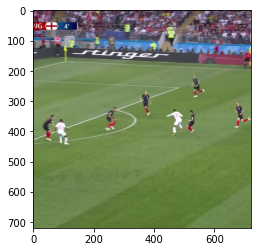

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/content/drive/MyDrive/Off_world_Project/SportsAnaly/soccer-lin/soccer-line-detection/models/generate_model.py:40: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.real_A = Variable(self.input_A, volatile = True)


0128: process image... 


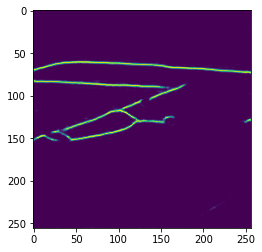

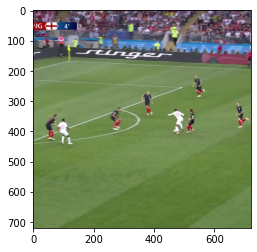

0129: process image... 


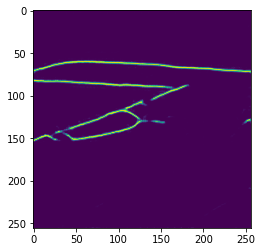

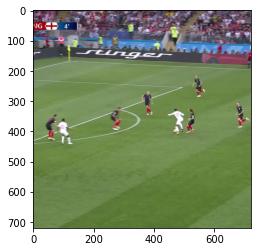

0130: process image... 


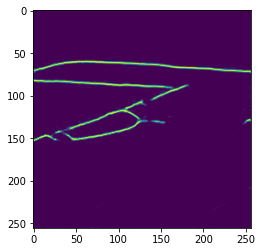

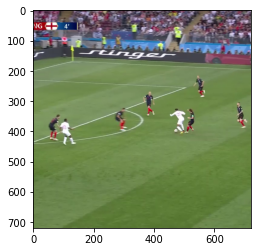

0131: process image... 


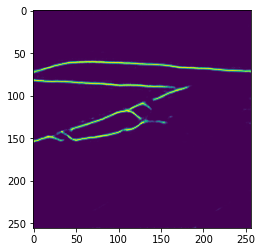

In [ ]:
cap = cv2.VideoCapture("./videos/engVsCroTrim.mp4")
counter = 0
para = None
para_ret = None
while(True):
    counter += 1
    ret, frame = cap.read()
    if frame is None:
        break
    if is_longview(frame, ssd_model):
        img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        w, h = img.size
        box = (int(w/2-h/2), 0, int(w/2+h/2), h)
        img = img.crop(box)
        plt.imshow(img)
        plt.show()
        transform = get_transform(opt)
        input_img = transform(img)
        input_img = {'A':input_img.unsqueeze(0), 'A_paths': ""}
        GAN_line_detection(input_img, counter)
    
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

In [ ]:
cd ..

/content/drive/MyDrive/Off_world_Project/SportsAnaly/soccer-lin
